In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage.feature import canny
from sklearn.ensemble import RandomForestClassifier



# **reading the data**

In [2]:
SIZE = 224  # Set your desired image size

train_dir = "../input/signature-verification-dataset/sign_data/train"
test_dir = "../input/signature-verification-dataset/sign_data/test"

real_images = []
forged_images = []

for per in os.listdir(train_dir):
    for data in glob.glob(os.path.join(train_dir, per, '*.*')):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (SIZE, SIZE))

        if per[-1] == 'g':
            forged_images.append(img)
        else:
            real_images.append(img)

real_images = np.array(real_images)
forged_images = np.array(forged_images)

real_labels = np.zeros((real_images.shape[0], 1))
forged_labels = np.ones((forged_images.shape[0], 1))

# Concatenate the real and forged images and labels
images = np.concatenate((real_images, forged_images))
labels = np.concatenate((real_labels, forged_labels))

# Flatten the images
images = images.reshape(images.shape[0], -1)

# Split the data into training and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [3]:
print(train_labels.shape)

(1319, 1)


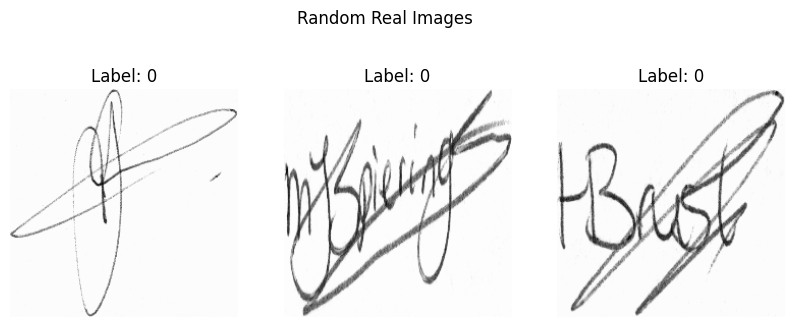

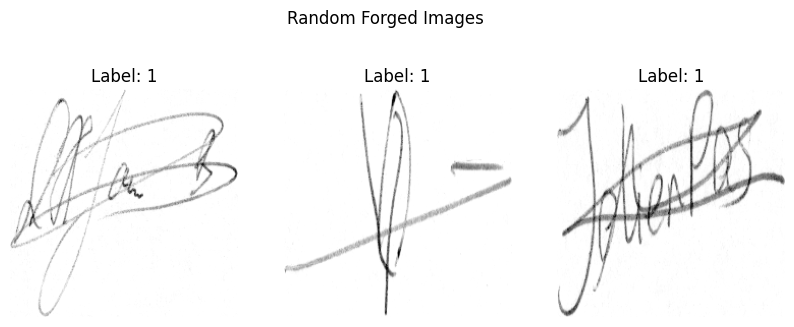

In [4]:
# Function to display random images
def show_random_images(images, labels, title):
    plt.figure(figsize=(10, 4))
    
    # Get a random sample of 9 indices
    random_indices = random.sample(range(len(images)), min(3, len(images)))
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {int(labels[idx])}")
        plt.axis("off")
    
    plt.suptitle(title)
    plt.show()

# Display a random set of real images
show_random_images(real_images, real_labels, "Random Real Images")

# Display a random set of forged images
show_random_images(forged_images, forged_labels, "Random Forged Images")

# **Applying SVM without preprocessing**

In [5]:

# Standardize the features (important for SVM)
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Create a Polynomial SVM classifier
svm_classifier = svm.SVC(kernel='poly')

# You can use GridSearchCV to find the best hyperparameters
# parameters = {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0.0, 0.1, 1.0]}
# svm_classifier = GridSearchCV(svm.SVC(kernel='poly'), parameters, cv=3)

# Train the classifier
svm_classifier.fit(train_data, train_labels.ravel())

# Make predictions on the test set
y_pred = svm_classifier.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
report = classification_report(test_labels, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.5515151515151515
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       182
         1.0       0.00      0.00      0.00       148

    accuracy                           0.55       330
   macro avg       0.28      0.50      0.36       330
weighted avg       0.30      0.55      0.39       330



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **PreProcessing**

In [6]:
def apply_adaptive_threshold(img, block_size=21, c=7):
    img_adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size,c)
    return img_adaptive

In [7]:
def clean_signature(img, threshold):
    img_cleaned = cv2.medianBlur(img, threshold)
    return img_cleaned

In [8]:
def whiten_black_neighbours(img, threshold):
  """
  Replaces black pixels with white if they have at least `threshold` white neighbours.

  Args:
    img: A 2D numpy array representing the image.
    threshold: The minimum number of white neighbours required to whiten a black pixel.

  Returns:
    A new 2D numpy array with replaced black pixels.
  """
  # Create a copy of the image
  white_img = img.copy()

  # Define the search directions for neighbours
  directions = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1), (0, 1),
               (1, -1), (1, 0), (1, 1)]

  # Iterate over each pixel
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      # Check if the pixel is black
      if img[row, col] == 0:
        # Count the number of white neighbours
        white_neighbours = 0
        for dx, dy in directions:
          neighbour_row, neighbour_col = row + dy, col + dx
          # Check if neighbour is within image bounds
          if 0 <= neighbour_row < img.shape[0] and 0 <= neighbour_col < img.shape[1]:
            if img[neighbour_row, neighbour_col] == 255:
              white_neighbours += 1

        # If the number of white neighbours is greater than or equal to the threshold, whiten the pixel
        if white_neighbours >= threshold:
          white_img[row, col] = 255

  return white_img

In [9]:
def trim_zeros(arr, threshold):
  """
  Trims rows and columns of a 2D array with too many zeros.

  Args:
    arr: A 2D numpy array.
    threshold: The maximum number of zeros allowed in a row or column.

  Returns:
    A trimmed 2D numpy array.
  """
  # Trim rows
  row_sums = np.sum(arr, axis=1)
  keep_rows = row_sums > threshold
  trimmed_arr = arr[keep_rows, :]

  # Trim columns
  col_sums = np.sum(trimmed_arr, axis=0)
  keep_cols = col_sums > threshold
  trimmed_arr = trimmed_arr[:, keep_cols]
  trimmed_arr = trimmed_arr.astype(np.uint8)
  trimmed_arr = cv2.resize(trimmed_arr, (SIZE, SIZE))
  # Resize the array back to its original size
  # trimmed_arr = np.pad(trimmed_arr, ((0, arr.shape[0] - trimmed_arr.shape[0]),
  #                                     (0, arr.shape[1] - trimmed_arr.shape[1])),
  #                       mode='constant', constant_values=0)
  return trimmed_arr

In [10]:
def trim_white(arr, threshold):
  """
  Trims rows and columns of a 2D array with too many 255s (white pixels).

  Args:
    arr: A 2D numpy array.
    threshold: The maximum number of 255s allowed in a row or column.

  Returns:
    A trimmed 2D numpy array.
  """
  # Invert the array to treat 255s as zeros
  inverted_arr = 255 - arr
  # Use the original function to trim rows and columns based on zeros
  trimmed_arr = trim_zeros(inverted_arr, threshold)
  # Invert the trimmed array back to original values
  trimmed_arr = 255 - trimmed_arr
  # Convert the data type to uint8 for image processing
  trimmed_arr = trimmed_arr.astype(np.uint8)
  # Resize the array to the desired size
  trimmed_arr = cv2.resize(trimmed_arr, (SIZE, SIZE))
  return trimmed_arr

In [11]:
def thining(img):
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)
    binary_image = cv2.bitwise_not(blurred_image)
    
    thinning_image = cv2.ximgproc.thinning(binary_image)
    
    return thinning_image

In [12]:
def process_image_pipeline(img):
   img = apply_adaptive_threshold(img, 55,6)
   img = clean_signature(img,3)
#    img = whiten_black_neighbours(img , 4)
#    img = trim_white(img, 180)
#    img = thining(img) 

   return img

In [13]:
# Process the images using the defined pipeline
processed_real_images = [process_image_pipeline(img) for img in real_images]
processed_forged_images = [process_image_pipeline(img) for img in forged_images]

# Convert processed images to numpy arrays
processed_real_images = np.array(processed_real_images)
processed_forged_images = np.array(processed_forged_images)

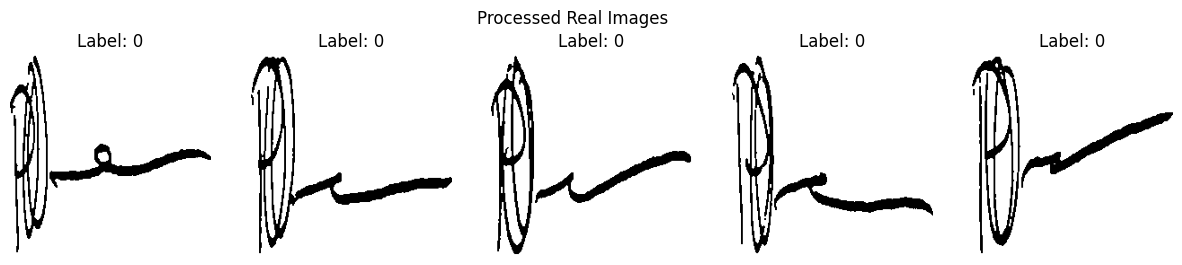

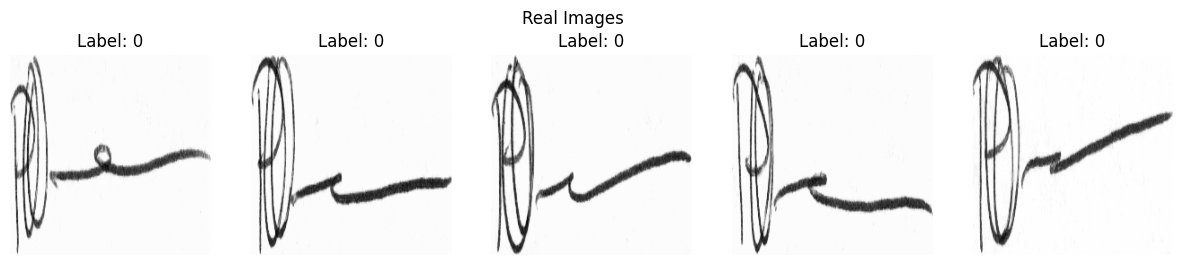

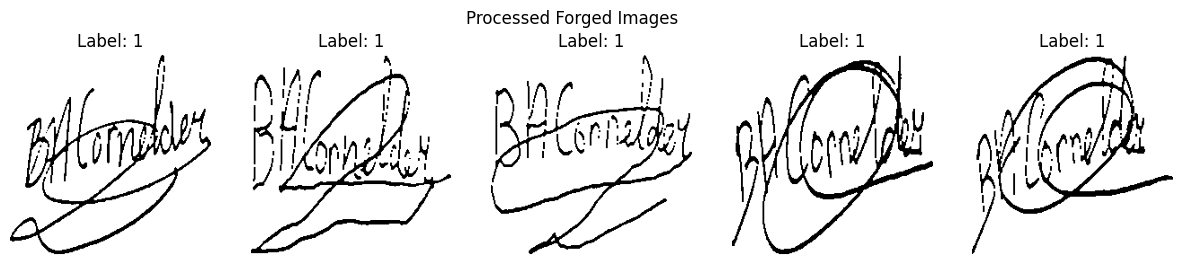

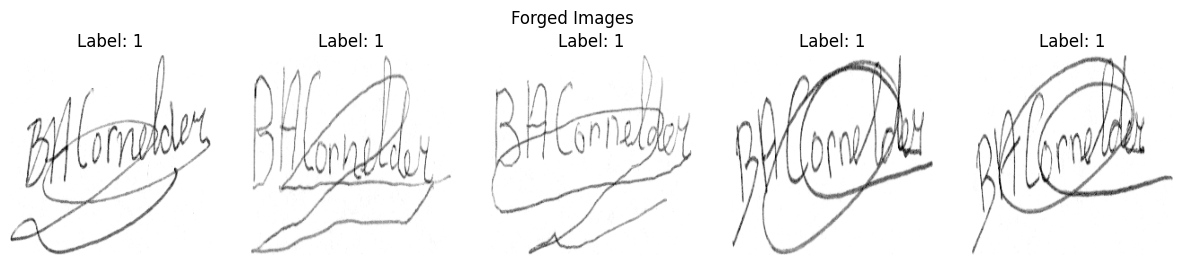

In [14]:
def visualize_images(images, labels, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title)
    
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {int(label)}')
        axes[i].axis('off')
    
    plt.show()

# Visualize some processed real images
visualize_images(processed_real_images[:5], real_labels[:5], title='Processed Real Images')
visualize_images(real_images[:5], real_labels[:5], title='Real Images')

# Visualize some processed forged images
visualize_images(processed_forged_images[:5], forged_labels[:5], title='Processed Forged Images')
visualize_images(forged_images[:5], forged_labels[:5], title='Forged Images')

# **Applying the SVM after preprocessing**

In [15]:
# Concatenate the processed real and forged images
processed_images = np.concatenate((processed_real_images, processed_forged_images))

# Flatten the processed images
processed_images = processed_images.reshape(processed_images.shape[0], -1)

# Split the processed data into training and validation sets
processed_train_data, processed_test_data, processed_train_labels, processed_test_labels = train_test_split(
    processed_images, labels, test_size=0.2, random_state=42
)

# Standardize the processed features (important for SVM)
processed_train_data = scaler.fit_transform(processed_train_data)
processed_test_data = scaler.transform(processed_test_data)

# Create a Polynomial SVM classifier for processed data
processed_svm_classifier = svm.SVC(kernel='poly')

# Train the classifier on processed data
processed_svm_classifier.fit(processed_train_data, processed_train_labels.ravel())

# Make predictions on the processed test set
processed_y_pred = processed_svm_classifier.predict(processed_test_data)

# Evaluate the model on processed data
processed_accuracy = accuracy_score(processed_test_labels, processed_y_pred)
processed_report = classification_report(processed_test_labels, processed_y_pred)

print("Accuracy on Processed Data:", processed_accuracy)
print("Classification Report on Processed Data:\n", processed_report)


Accuracy on Processed Data: 0.5545454545454546
Classification Report on Processed Data:
               precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       182
         1.0       1.00      0.01      0.01       148

    accuracy                           0.55       330
   macro avg       0.78      0.50      0.36       330
weighted avg       0.75      0.55      0.40       330



# **Feature extraction**

In [16]:
!pip install --upgrade scikit-image
!pip install --upgrade scipy


  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.21.0
    Uninstalling scikit-image-0.21.0:
      Successfully uninstalled scikit-image-0.21.0


# Extracting Histogram of Oriented Gradients (HOG):
HOG captures the distribution of gradients in different parts of an image and can be effective for capturing shape information.



In [17]:

# Define a function to compute HOG features for a single image
def compute_hog_features(img):
    features, _ = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return features

# Compute HOG features for each image
hog_real_images = np.array([compute_hog_features(img) for img in real_images])
hog_forged_images = np.array([compute_hog_features(img) for img in forged_images])

# Concatenate the HOG features
hog_features = np.concatenate((hog_real_images, hog_forged_images))

# Flatten the HOG features
hog_features = hog_features.reshape(hog_features.shape[0], -1)

# Split the data into training and validation sets
hog_train_data, hog_test_data, hog_train_labels, hog_test_labels = train_test_split(
    hog_features, labels, test_size=0.2, random_state=42
)

# Standardize the HOG features (important for SVM)
hog_scaler = StandardScaler()
hog_train_data = hog_scaler.fit_transform(hog_train_data)
hog_test_data = hog_scaler.transform(hog_test_data)



In [18]:
# Create a Polynomial SVM classifier for HOG features
hog_svm_classifier = svm.SVC(kernel='sigmoid')

# Train the classifier on HOG features
hog_svm_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred = hog_svm_classifier.predict(hog_test_data)

# Evaluate the model on HOG features
hog_accuracy = accuracy_score(hog_test_labels, hog_y_pred)
hog_report = classification_report(hog_test_labels, hog_y_pred)

print("Accuracy on HOG Features:", hog_accuracy)
print("Classification Report on HOG Features:\n", hog_report)

Accuracy on HOG Features: 0.7515151515151515
Classification Report on HOG Features:
               precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       182
         1.0       0.71      0.74      0.73       148

    accuracy                           0.75       330
   macro avg       0.75      0.75      0.75       330
weighted avg       0.75      0.75      0.75       330



# Grid search

this is one of the remarkable results:

In [19]:
# Create a Polynomial SVM classifier for HOG features
svm_classifier = svm.SVC(kernel='poly')

# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0.0, 0.1, 1.0]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3)
grid_search.fit(hog_train_data, hog_train_labels.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the classifier with the best parameters
best_svm_classifier = svm.SVC(kernel='poly', C=best_params['C'], degree=best_params['degree'], coef0=best_params['coef0'])
best_svm_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred = best_svm_classifier.predict(hog_test_data)

# Evaluate the model on HOG features
hog_accuracy = accuracy_score(hog_test_labels, hog_y_pred)
hog_report = classification_report(hog_test_labels, hog_y_pred)

print("Best Parameters:", best_params)
print("Accuracy on HOG Features:", hog_accuracy)
print("Classification Report on HOG Features:\n", hog_report)



Best Parameters: {'C': 10, 'coef0': 0.1, 'degree': 2}
Accuracy on HOG Features: 0.8545454545454545
Classification Report on HOG Features:
               precision    recall  f1-score   support

         0.0       0.92      0.81      0.86       182
         1.0       0.79      0.91      0.85       148

    accuracy                           0.85       330
   macro avg       0.86      0.86      0.85       330
weighted avg       0.86      0.85      0.85       330



another svm kernal

In [20]:
rbf_svm_classifier = svm.SVC(kernel='rbf')
param_grid = {'C': [10, 15, 50],  'gamma': ['scale', 'auto'],  'degree': [2, 5,], 'coef0': [0.0, 0.05,0.1]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rbf_svm_classifier, param_grid, cv=3)
grid_search.fit(hog_train_data, hog_train_labels.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the classifier with the best parameters
best_rbf_svm_classifier = svm.SVC(kernel='rbf', C=best_params['C'],gamma=best_params['gamma'] , degree=best_params['degree'], coef0=best_params['coef0'])

best_rbf_svm_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred = best_rbf_svm_classifier.predict(hog_test_data)

# Evaluate the model on HOG features
hog_accuracy = accuracy_score(hog_test_labels, hog_y_pred)
hog_report = classification_report(hog_test_labels, hog_y_pred)

print("Accuracy on HOG Features:", hog_accuracy)
print("Classification Report on HOG Features:\n", hog_report)


Accuracy on HOG Features: 0.8303030303030303
Classification Report on HOG Features:
               precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       182
         1.0       0.82      0.80      0.81       148

    accuracy                           0.83       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.83      0.83      0.83       330



In [21]:
print("Best Parameters:", best_params)

Best Parameters: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale'}


# voting (ensemble learning) using the 2 different kernals and failing to enhance

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Create the individual classifiers with the best parameters
best_poly_svm_classifier = SVC(kernel='poly', C=10, degree=2, coef0=0.1, probability=True)
best_rbf_svm_classifier = SVC(kernel='rbf', C=10, degree=2, coef0=0.0,probability=True)

# Create a voting classifier (ensemble)
ensemble_classifier = VotingClassifier(
    estimators=[
        ('poly_svm', best_poly_svm_classifier),
        ('rbf_svm', best_rbf_svm_classifier),
    ],
    voting='soft'  # Use 'hard' for majority voting
)

# Train the ensemble classifier
ensemble_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred_ensemble = ensemble_classifier.predict(hog_test_data)

# Evaluate the ensemble model on HOG features
ensemble_accuracy = accuracy_score(hog_test_labels, hog_y_pred_ensemble)
ensemble_report = classification_report(hog_test_labels, hog_y_pred_ensemble)

print("Accuracy of Ensemble Classifier:", ensemble_accuracy)
print("Classification Report of Ensemble Classifier:\n", ensemble_report)


Accuracy of Ensemble Classifier: 0.8424242424242424
Classification Report of Ensemble Classifier:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       182
         1.0       0.81      0.84      0.83       148

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



# Extracting Local Binary Patterns (LBP): 
which describe the local texture pattern of an image. LBP is particularly useful for texture-based classification.

# (we here combine the 2 features hog & lbp)

In [23]:
from skimage.feature import local_binary_pattern


# Define a function to compute LBP features for a single image
def compute_lbp_features(img):
    # Convert the image to uint8 if it's not already
    img = img.astype(np.uint8)
    
    # Compute LBP features
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    
    # Flatten the LBP features
    return lbp.flatten()

# Compute LBP features for each image
lbp_real_images = np.array([compute_lbp_features(img) for img in real_images])
lbp_forged_images = np.array([compute_lbp_features(img) for img in forged_images])

# Concatenate the LBP features
lbp_features = np.concatenate((lbp_real_images, lbp_forged_images))

# Flatten the LBP features
lbp_features = lbp_features.reshape(lbp_features.shape[0], -1)

# Split the data into training and validation sets
lbp_train_data, lbp_test_data, lbp_train_labels, lbp_test_labels = train_test_split(
    lbp_features, labels, test_size=0.2, random_state=42
)

# Standardize the LBP features (important for SVM)
lbp_scaler = StandardScaler()
lbp_train_data = lbp_scaler.fit_transform(lbp_train_data)
lbp_test_data = lbp_scaler.transform(lbp_test_data)


In [24]:

# Concatenate HOG and LBP features
combined_features_train = np.concatenate((hog_train_data, lbp_train_data), axis=1)
combined_features_test = np.concatenate((hog_test_data, lbp_test_data), axis=1)

# Create a Polynomial SVM classifier for combined features
svm_classifier_combined = svm.SVC(kernel='poly', C=10, degree=2, coef0=0.1)
svm_classifier_combined.fit(combined_features_train, lbp_train_labels.ravel())

# Make predictions on the combined test set
combined_y_pred = svm_classifier_combined.predict(combined_features_test)

# Evaluate the model on combined features
combined_accuracy = accuracy_score(lbp_test_labels, combined_y_pred)
combined_report = classification_report(lbp_test_labels, combined_y_pred)

print("Accuracy on Combined Features:", combined_accuracy)
print("Classification Report on Combined Features:\n", combined_report)


Accuracy on Combined Features: 0.7666666666666667
Classification Report on Combined Features:
               precision    recall  f1-score   support

         0.0       0.85      0.70      0.77       182
         1.0       0.70      0.84      0.76       148

    accuracy                           0.77       330
   macro avg       0.77      0.77      0.77       330
weighted avg       0.78      0.77      0.77       330



# Trying rondem forest classifier on combined features

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on combined features
rf_classifier.fit(combined_features_train, lbp_train_labels.ravel())

# Make predictions on the combined test set
rf_y_pred = rf_classifier.predict(combined_features_test)

# Evaluate the model on combined features
rf_accuracy = accuracy_score(lbp_test_labels, rf_y_pred)
rf_report = classification_report(lbp_test_labels, rf_y_pred)

print("Accuracy with Random Forest:", rf_accuracy)
print("Classification Report with Random Forest:\n", rf_report)


Accuracy with Random Forest: 0.703030303030303
Classification Report with Random Forest:
               precision    recall  f1-score   support

         0.0       0.77      0.65      0.71       182
         1.0       0.64      0.76      0.70       148

    accuracy                           0.70       330
   macro avg       0.71      0.71      0.70       330
weighted avg       0.71      0.70      0.70       330



# Random forest on lbp only

In [26]:

# Create a Random Forest classifier for LBP features
rf_classifier_lbp = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on LBP features
rf_classifier_lbp.fit(lbp_train_data, lbp_train_labels.ravel())

# Make predictions on the LBP test set
rf_y_pred_lbp = rf_classifier_lbp.predict(lbp_test_data)

# Evaluate the model on LBP features
rf_accuracy_lbp = accuracy_score(lbp_test_labels, rf_y_pred_lbp)
rf_report_lbp = classification_report(lbp_test_labels, rf_y_pred_lbp)

print("Accuracy with Random Forest on LBP:", rf_accuracy_lbp)
print("Classification Report with Random Forest on LBP:\n", rf_report_lbp)


Accuracy with Random Forest on LBP: 0.706060606060606
Classification Report with Random Forest on LBP:
               precision    recall  f1-score   support

         0.0       0.75      0.69      0.72       182
         1.0       0.66      0.72      0.69       148

    accuracy                           0.71       330
   macro avg       0.71      0.71      0.71       330
weighted avg       0.71      0.71      0.71       330



# Random forest on hog only

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier for HOG features
rf_classifier_hog = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on HOG features
rf_classifier_hog.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
rf_y_pred_hog = rf_classifier_hog.predict(hog_test_data)

# Evaluate the model on HOG features
rf_accuracy_hog = accuracy_score(hog_test_labels, rf_y_pred_hog)
rf_report_hog = classification_report(hog_test_labels, rf_y_pred_hog)

print("Accuracy with Random Forest on HOG:", rf_accuracy_hog)
print("Classification Report with Random Forest on HOG:\n", rf_report_hog)


Accuracy with Random Forest on HOG: 0.7666666666666667
Classification Report with Random Forest on HOG:
               precision    recall  f1-score   support

         0.0       0.79      0.78      0.79       182
         1.0       0.74      0.75      0.74       148

    accuracy                           0.77       330
   macro avg       0.76      0.77      0.76       330
weighted avg       0.77      0.77      0.77       330



# SVM on lbp only

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Create a Polynomial SVM classifier for LBP features
svm_classifier_lbp = SVC(kernel='rbf')
svm_classifier_lbp.fit(lbp_train_data, lbp_train_labels.ravel())

# Make predictions on the LBP test set
svm_y_pred_lbp = svm_classifier_lbp.predict(lbp_test_data)

# Evaluate the model on LBP features
svm_accuracy_lbp = accuracy_score(lbp_test_labels, svm_y_pred_lbp)
svm_report_lbp = classification_report(lbp_test_labels, svm_y_pred_lbp)

print("Accuracy with rbf SVM on LBP:", svm_accuracy_lbp)
print("Classification Report with rbf SVM on LBP:\n", svm_report_lbp)


Accuracy with rbf SVM on LBP: 0.7212121212121212
Classification Report with rbf SVM on LBP:
               precision    recall  f1-score   support

         0.0       0.82      0.63      0.71       182
         1.0       0.65      0.83      0.73       148

    accuracy                           0.72       330
   macro avg       0.73      0.73      0.72       330
weighted avg       0.74      0.72      0.72       330



# Edge Features 

In [29]:

# Define a function to compute edge features for a single image
def compute_edge_features(img):
    # Apply Canny edge detector
    edges = canny(img)
    
    # Flatten the edge features
    return edges.flatten()

# Compute edge features for each image
edge_real_images = np.array([compute_edge_features(img) for img in real_images])
edge_forged_images = np.array([compute_edge_features(img) for img in forged_images])

# Concatenate the edge features
edge_features = np.concatenate((edge_real_images, edge_forged_images))

# Flatten the edge features
edge_features = edge_features.reshape(edge_features.shape[0], -1)

# Split the data into training and validation sets
edge_train_data, edge_test_data, edge_train_labels, edge_test_labels = train_test_split(
    edge_features, labels, test_size=0.2, random_state=42
)



In [30]:
# Create a Random Forest classifier for edge features
rf_classifier_edge = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on edge features
rf_classifier_edge.fit(edge_train_data, edge_train_labels.ravel())

# Make predictions on the edge test set
rf_y_pred_edge = rf_classifier_edge.predict(edge_test_data)

# Evaluate the model on edge features
rf_accuracy_edge = accuracy_score(edge_test_labels, rf_y_pred_edge)
rf_report_edge = classification_report(edge_test_labels, rf_y_pred_edge)

print("Accuracy with Random Forest on Edge Features:", rf_accuracy_edge)
print("Classification Report with Random Forest on Edge Features:\n", rf_report_edge)


Accuracy with Random Forest on Edge Features: 0.5969696969696969
Classification Report with Random Forest on Edge Features:
               precision    recall  f1-score   support

         0.0       0.64      0.62      0.63       182
         1.0       0.55      0.57      0.56       148

    accuracy                           0.60       330
   macro avg       0.59      0.59      0.59       330
weighted avg       0.60      0.60      0.60       330



In [31]:
from skimage.feature import canny
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Split the data into training and validation sets
edge_train_data, edge_test_data, edge_train_labels, edge_test_labels = train_test_split(
    edge_features, labels, test_size=0.2, random_state=42
)

# Standardize the edge features (important for SVM)
edge_scaler = StandardScaler()
edge_train_data = edge_scaler.fit_transform(edge_train_data)
edge_test_data = edge_scaler.transform(edge_test_data)

# Create a Polynomial SVM classifier for edge features
svm_classifier_edge = SVC(kernel='poly')
svm_classifier_edge.fit(edge_train_data, edge_train_labels.ravel())

# Make predictions on the edge test set
svm_y_pred_edge = svm_classifier_edge.predict(edge_test_data)

# Evaluate the model on edge features
svm_accuracy_edge = accuracy_score(edge_test_labels, svm_y_pred_edge)
svm_report_edge = classification_report(edge_test_labels, svm_y_pred_edge)

print("Accuracy with Polynomial SVM on Edge Features:", svm_accuracy_edge)
print("Classification Report with Polynomial SVM on Edge Features:\n", svm_report_edge)


Accuracy with Polynomial SVM on Edge Features: 0.5515151515151515
Classification Report with Polynomial SVM on Edge Features:
               precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       182
         1.0       0.00      0.00      0.00       148

    accuracy                           0.55       330
   macro avg       0.28      0.50      0.36       330
weighted avg       0.30      0.55      0.39       330



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from skimage.feature import canny
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Split the data into training and validation sets
edge_train_data, edge_test_data, edge_train_labels, edge_test_labels = train_test_split(
    edge_features, labels, test_size=0.2, random_state=42
)

# Standardize the edge features (important for SVM)
edge_scaler = StandardScaler()
edge_train_data = edge_scaler.fit_transform(edge_train_data)
edge_test_data = edge_scaler.transform(edge_test_data)

# Create a Polynomial SVM classifier for edge features
svm_classifier_edge = SVC(kernel='rbf')
svm_classifier_edge.fit(edge_train_data, edge_train_labels.ravel())

# Make predictions on the edge test set
svm_y_pred_edge = svm_classifier_edge.predict(edge_test_data)

# Evaluate the model on edge features
svm_accuracy_edge = accuracy_score(edge_test_labels, svm_y_pred_edge)
svm_report_edge = classification_report(edge_test_labels, svm_y_pred_edge)

print("Accuracy with rbf SVM on Edge Features:", svm_accuracy_edge)
print("Classification Report with rbf SVM on Edge Features:\n", svm_report_edge)


Accuracy with rbf SVM on Edge Features: 0.6090909090909091
Classification Report with rbf SVM on Edge Features:
               precision    recall  f1-score   support

         0.0       0.62      0.76      0.68       182
         1.0       0.59      0.43      0.49       148

    accuracy                           0.61       330
   macro avg       0.60      0.59      0.59       330
weighted avg       0.61      0.61      0.60       330



# voting 

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the individual classifiers
rf_hog = RandomForestClassifier(n_estimators=100, random_state=42)
svm_hog = SVC(kernel='poly', C=10, coef0=0.1, degree=2)
rf_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
svm_lbp = SVC(kernel='poly', C=10, coef0=0.1, degree=2)
rf_edge = RandomForestClassifier(n_estimators=100, random_state=42)
svm_edge = SVC(kernel='poly', C=10, coef0=0.1, degree=2)

# Create a Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf_hog', rf_hog),
        ('svm_hog', svm_hog),
        ('rf_lbp', rf_lbp),
#         ('svm_lbp', svm_lbp),
#         ('rf_edge', rf_edge),
#         ('svm_edge', svm_edge),
    ],
    voting='hard'  # Use 'soft' for weighted voting
)

# Train the Voting Classifier
voting_classifier.fit(combined_features_train, lbp_train_labels.ravel())

# Make predictions on the combined test set
voting_y_pred = voting_classifier.predict(combined_features_test)

# Evaluate the Voting Classifier
voting_accuracy = accuracy_score(lbp_test_labels, voting_y_pred)
voting_report = classification_report(lbp_test_labels, voting_y_pred)

print("Accuracy with Voting Classifier:", voting_accuracy)
print("Classification Report with Voting Classifier:\n", voting_report)


Accuracy with Voting Classifier: 0.703030303030303
Classification Report with Voting Classifier:
               precision    recall  f1-score   support

         0.0       0.77      0.65      0.71       182
         1.0       0.64      0.76      0.70       148

    accuracy                           0.70       330
   macro avg       0.71      0.71      0.70       330
weighted avg       0.71      0.70      0.70       330



In [34]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the individual classifiers
rf_hog = RandomForestClassifier(n_estimators=100, random_state=42)
svm_hog = SVC(kernel='poly', C=10, coef0=0.1, degree=2, probability=True)
rf_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
svm_lbp = SVC(kernel='poly', C=10, coef0=0.1, degree=2 ,probability=True)
rf_edge = RandomForestClassifier(n_estimators=100, random_state=42)
svm_edge = SVC(kernel='poly', C=10, coef0=0.1, degree=2, probability=True)

# Create a Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf_hog', rf_hog),
        ('svm_hog', svm_hog),
        ('rf_lbp', rf_lbp),
#         ('svm_lbp', svm_lbp),
#         ('rf_edge', rf_edge),
#         ('svm_edge', svm_edge),
    ],
    voting='soft'  # Use 'soft' for weighted voting
)

# Train the Voting Classifier
voting_classifier.fit(combined_features_train, lbp_train_labels.ravel())

# Make predictions on the combined test set
voting_y_pred = voting_classifier.predict(combined_features_test)

# Evaluate the Voting Classifier
voting_accuracy = accuracy_score(lbp_test_labels, voting_y_pred)
voting_report = classification_report(lbp_test_labels, voting_y_pred)

print("Accuracy with Voting Classifier:", voting_accuracy)
print("Classification Report with Voting Classifier:\n", voting_report)


Accuracy with Voting Classifier: 0.7636363636363637
Classification Report with Voting Classifier:
               precision    recall  f1-score   support

         0.0       0.85      0.69      0.76       182
         1.0       0.69      0.85      0.76       148

    accuracy                           0.76       330
   macro avg       0.77      0.77      0.76       330
weighted avg       0.78      0.76      0.76       330



In [35]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Standardize the features (important for SVM)
combined_features_train_std = StandardScaler().fit_transform(combined_features_train)
combined_features_test_std = StandardScaler().fit_transform(combined_features_test)

# Define the individual classifiers
rf_hog = RandomForestClassifier(n_estimators=100, random_state=42)
svm_hog = SVC(kernel='poly', C=10, coef0=0.1, degree=2)
rf_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
svm_lbp = SVC(kernel='poly', C=10, coef0=0.1, degree=2)
rf_edge = RandomForestClassifier(n_estimators=100, random_state=42)
svm_edge = SVC(kernel='poly', C=10, coef0=0.1, degree=2)

# Create a Stacking Classifier with Random Forest as the meta-classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('rf_hog', rf_hog),
        ('svm_hog', svm_hog),
        ('rf_lbp', rf_lbp),
#         ('svm_lbp', svm_lbp),
#         ('rf_edge', rf_edge),
#         ('svm_edge', svm_edge),
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    stack_method='auto',  # Use 'auto' to automatically choose the method
    cv=3  # Number of cross-validation folds for stacking
)

# Train the Stacking Classifier
stacking_classifier.fit(combined_features_train_std, lbp_train_labels.ravel())

# Make predictions on the combined test set
stacking_y_pred = stacking_classifier.predict(combined_features_test_std)

# Evaluate the Stacking Classifier
stacking_accuracy = accuracy_score(lbp_test_labels, stacking_y_pred)
stacking_report = classification_report(lbp_test_labels, stacking_y_pred)

print("Accuracy with Stacking Classifier:", stacking_accuracy)
print("Classification Report with Stacking Classifier:\n", stacking_report)


Accuracy with Stacking Classifier: 0.6909090909090909
Classification Report with Stacking Classifier:
               precision    recall  f1-score   support

         0.0       0.73      0.69      0.71       182
         1.0       0.65      0.69      0.67       148

    accuracy                           0.69       330
   macro avg       0.69      0.69      0.69       330
weighted avg       0.69      0.69      0.69       330



# Wavelet Transform features

In [36]:
import cv2
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import pywt

# Function to apply 2D wavelet transform
def apply_wavelet_transform(img):
    coeffs = pywt.dwt2(img, 'bior1.3')
    cA, (cH, cV, cD) = coeffs
    return cA.flatten()

# Load and preprocess data
# (Assuming you have real_images, forged_images, labels, train_data, test_data, train_labels, test_labels from previous code)

# Apply wavelet transform to each image
wavelet_real_images = np.array([apply_wavelet_transform(img) for img in real_images])
wavelet_forged_images = np.array([apply_wavelet_transform(img) for img in forged_images])

# Concatenate the wavelet features
wavelet_features = np.concatenate((wavelet_real_images, wavelet_forged_images))

# Split the data into training and validation sets
wavelet_train_data, wavelet_test_data, wavelet_train_labels, wavelet_test_labels = train_test_split(
    wavelet_features, labels, test_size=0.2, random_state=42
)



In [37]:
# SVM classifier
svm_classifier_wavelet = SVC(kernel='rbf')
svm_classifier_wavelet.fit(wavelet_train_data, wavelet_train_labels.ravel())
svm_y_pred_wavelet = svm_classifier_wavelet.predict(wavelet_test_data)


# Evaluate classifiers
svm_accuracy_wavelet = accuracy_score(wavelet_test_labels, svm_y_pred_wavelet)

svm_report_wavelet = classification_report(wavelet_test_labels, svm_y_pred_wavelet)


print("SVM Accuracy with Wavelet Features:", svm_accuracy_wavelet)
print("SVM Classification Report with Wavelet Features:\n", svm_report_wavelet)


SVM Accuracy with Wavelet Features: 0.7545454545454545
SVM Classification Report with Wavelet Features:
               precision    recall  f1-score   support

         0.0       0.74      0.86      0.79       182
         1.0       0.78      0.63      0.70       148

    accuracy                           0.75       330
   macro avg       0.76      0.74      0.75       330
weighted avg       0.76      0.75      0.75       330



In [38]:
# Random Forest classifier
rf_classifier_wavelet = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_wavelet.fit(wavelet_train_data, wavelet_train_labels.ravel())
rf_y_pred_wavelet = rf_classifier_wavelet.predict(wavelet_test_data)

rf_accuracy_wavelet = accuracy_score(wavelet_test_labels, rf_y_pred_wavelet)

rf_report_wavelet = classification_report(wavelet_test_labels, rf_y_pred_wavelet)


print("\nRandom Forest Accuracy with Wavelet Features:", rf_accuracy_wavelet)
print("Random Forest Classification Report with Wavelet Features:\n", rf_report_wavelet)



Random Forest Accuracy with Wavelet Features: 0.7606060606060606
Random Forest Classification Report with Wavelet Features:
               precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       182
         1.0       0.76      0.69      0.72       148

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.76       330
weighted avg       0.76      0.76      0.76       330



# KNN (best accuracy till now)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# Create a k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors (k)

# Train the k-NN classifier
knn_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred_knn = knn_classifier.predict(hog_test_data)

# Evaluate the k-NN model on HOG features
knn_accuracy = accuracy_score(hog_test_labels, hog_y_pred_knn)
knn_report = classification_report(hog_test_labels, hog_y_pred_knn)

print("Accuracy of k-NN Classifier:", knn_accuracy)
print("Classification Report of k-NN Classifier:\n", knn_report)


Accuracy of k-NN Classifier: 0.8666666666666667
Classification Report of k-NN Classifier:
               precision    recall  f1-score   support

         0.0       0.90      0.85      0.88       182
         1.0       0.83      0.89      0.86       148

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



# voting (best accuracy)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# Create the individual classifiers
knn_classifier = KNeighborsClassifier(n_neighbors=3)
poly_svm_classifier = svm.SVC(kernel='poly', C=10, degree=2, coef0=0.1, probability=True)

# Create a voting classifier (ensemble)
voting_classifier = VotingClassifier(
    estimators=[
        ('knn', knn_classifier),
        ('poly_svm', poly_svm_classifier),
    ],
    voting='soft'  # Use 'hard' for majority voting
)

# Train the ensemble classifier
voting_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred_voting = voting_classifier.predict(hog_test_data)

# Evaluate the ensemble model
voting_accuracy = accuracy_score(hog_test_labels, hog_y_pred_voting)
voting_report = classification_report(hog_test_labels, hog_y_pred_voting)

print("Accuracy of Voting Classifier:", voting_accuracy)
print("Classification Report of Voting Classifier:\n", voting_report)



Accuracy of Voting Classifier: 0.8787878787878788
Classification Report of Voting Classifier:
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89       182
         1.0       0.84      0.91      0.87       148

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Create the individual classifiers
knn_classifier = KNeighborsClassifier(n_neighbors=3)
poly_svm_classifier = SVC(kernel='poly', C=10, degree=2, coef0=0.1, probability=True )
rbf_svm_classifier = SVC(kernel='rbf', C=10, gamma='scale', degree=2, coef0=0.1,  probability=True)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a voting classifier (ensemble)
voting_classifier = VotingClassifier(
    estimators=[
        ('knn', knn_classifier),
        ('poly_svm', poly_svm_classifier),
        ('rbf_svm', rbf_svm_classifier),
        ('rf', rf_classifier),
    ],
    voting='soft'  # Use 'hard' for majority voting
)

# Train the ensemble classifier
voting_classifier.fit(hog_train_data, hog_train_labels.ravel())

# Make predictions on the HOG test set
hog_y_pred_voting = voting_classifier.predict(hog_test_data)

# Evaluate the ensemble model
voting_accuracy = accuracy_score(hog_test_labels, hog_y_pred_voting)
voting_report = classification_report(hog_test_labels, hog_y_pred_voting)

print("Accuracy of Voting Classifier:", voting_accuracy)
print("Classification Report of Voting Classifier:\n", voting_report)


Accuracy of Voting Classifier: 0.8666666666666667
Classification Report of Voting Classifier:
               precision    recall  f1-score   support

         0.0       0.91      0.85      0.87       182
         1.0       0.82      0.89      0.86       148

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330



# PCA

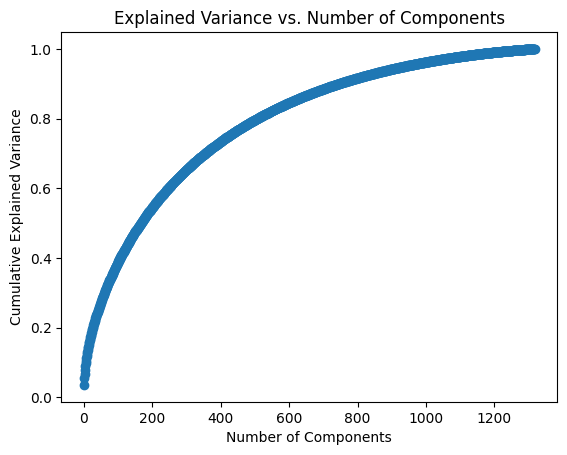

In [42]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# Concatenate the HOG, LBP, edge, and wavelet features
all_features = np.concatenate((hog_features, lbp_features, edge_features, wavelet_features), axis=1)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)

# Apply PCA to get the explained variance ratio for different number of components
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Plot the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


In [43]:
# Apply PCA to reduce dimensionality
n_components = 200
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train your classifier on the PCA-transformed features
svm_classifier = SVC(kernel='poly', C=10, degree=2, coef0=0.1)  
svm_classifier.fit(X_train_pca, y_train.ravel())

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy after PCA:", accuracy)
print("Classification Report after PCA:\n", report)


Accuracy after PCA: 0.7090909090909091
Classification Report after PCA:
               precision    recall  f1-score   support

         0.0       0.67      0.92      0.78       182
         1.0       0.82      0.45      0.58       148

    accuracy                           0.71       330
   macro avg       0.75      0.69      0.68       330
weighted avg       0.74      0.71      0.69       330



In [44]:
from sklearn.linear_model import LogisticRegression
n_components = 200
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Logistic Regression on the PCA-transformed features
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train_pca, y_train.ravel())

# Make predictions on the test set
y_pred = logreg_classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy with Logistic Regression and 200 PCA Components:", accuracy)
print("Classification Report:\n", report)

Accuracy with Logistic Regression and 200 PCA Components: 0.6303030303030303
Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.69      0.67       182
         1.0       0.59      0.55      0.57       148

    accuracy                           0.63       330
   macro avg       0.63      0.62      0.62       330
weighted avg       0.63      0.63      0.63       330



In [45]:
n_components = 20
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Random Forest on the PCA-transformed features
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train_pca, y_train.ravel())

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy with Random Forest and 200 PCA Components:", accuracy)
print("Classification Report:\n", report)

Accuracy with Random Forest and 200 PCA Components: 0.706060606060606
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.78      0.75       182
         1.0       0.69      0.61      0.65       148

    accuracy                           0.71       330
   macro avg       0.70      0.70      0.70       330
weighted avg       0.71      0.71      0.70       330

